# Partitioning Algorithm 
### Estimating $E_0$ and $R_{eco, ref}$ values for the NEE model based on the following equations:
#### Night-time Model ([Reichstein 2005])
#### $$NEE_{night} = R_{eco} = R_{eco,ref}e^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 
#### Day-time Model (Lasslop et al., 2010)
#### $$NEE_{day}=\frac{\alpha \beta R_g}{\alpha R_g + \beta} + \gamma$$


$$NEE = rbe^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 

$$\delta{NEE} = rbe^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 

In [1]:
from IPython.display import display, Math, Latex
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import numpy as np
import scipy
from scipy.stats import normaltest
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from astral.sun import sun
from astral import LocationInfo
import datetime
import bisect

## Flux Data Loading

In [2]:
def physics_nee(k, T, Tref=10, T0=46.02):
    e0 = k[:, 0]
    rb = k[:, 1]
    exp_term = np.exp(e0 * (1.0 / (Tref - T0) - 1.0 / (T - T0)))
    NEE = rb * exp_term
    return NEE

In [23]:
data_path = Path("./other_sites/redmere_2/processed_data.parquet")

flux_data_path = data_path
flux_data = pd.read_parquet(flux_data_path)

In [24]:
for col in flux_data.columns:
    flux_data[col] = flux_data[col].replace(-9999, np.nan)

In [25]:
flux_data["Date"] = flux_data["DateTime"].dt.date

In [26]:
flux_data['TimeDiff'] = flux_data['DateTime'].shift(-1) - flux_data['DateTime']
flux_data['dNEE'] = (flux_data['NEE'].shift(-1) - flux_data['NEE'])  / flux_data['TimeDiff'].dt.components.minutes
flux_data['dTa'] = (flux_data['Ta'].shift(-1) - flux_data['Ta'])  / flux_data['TimeDiff'].dt.components.minutes
flux_data['dRg'] = (flux_data['Rg'].shift(-1) - flux_data['Rg'])  / flux_data['TimeDiff'].dt.components.minutes
flux_data['NEE_next'] = flux_data['NEE'].shift(-1)

In [27]:
flux_data = flux_data.iloc[1:].reset_index(drop=True)

## Get Day/Night feature using Sunset and Sunrise Times

In [28]:
flux_data.columns

Index(['DateTime', 'NEE', 'H', 'Tau', 'LE', 'RH', 'VPD', 'Ustar', 'Ta',
       'Tsoil1', 'Rg', 'Date', 'TimeDiff', 'dNEE', 'dTa', 'dRg', 'NEE_next'],
      dtype='object')

In [32]:


# Example: Redmere coordinates
city = LocationInfo("Redmere", "UK", "Europe/London", 52.5, 0.2)
# city = LocationInfo(
#     name="Great Fen",
#     region="UK",
#     timezone="Europe/London",
#     latitude=52.484,
#     longitude=-0.180
# )
# city = LocationInfo(
#     name="Wicken Fen",
#     region="UK",
#     timezone="Europe/London",
#     latitude=52.309,
#     longitude=0.299
# )
# city = LocationInfo(
#     name="Woodwalton",
#     region="UK",
#     timezone="Europe/London",
#     latitude=52.413,
#     longitude=-0.2108421)


# Assume your DataFrame has a 'DateTime' column in pandas datetime format
flux_data['DateTime'] = pd.to_datetime(flux_data['DateTime'])
flux_data['DateTimeLocal'] = flux_data['DateTime'].dt.tz_localize('Europe/London', ambiguous='NaT', nonexistent='shift_forward')


# Get unique dates
flux_data['date'] = flux_data['DateTimeLocal'].dt.date
unique_dates = flux_data['date'].unique()

valid_dates = [d for d in unique_dates if pd.notnull(d)]


In [33]:

# Calculate sunrise/sunset for each date
sun_times = {}
for d in valid_dates:
    s = sun(city.observer, date=d)
    sun_times[d] = {'sunrise': s['sunrise'], 'sunset': s['sunset']}

available_dates = sorted(sun_times.keys())


In [34]:

def get_nearest_previous_date(d):
    """Return the nearest previous date in available_dates for date d."""
    if pd.isnull(d):
        return None
    pos = bisect.bisect_right(available_dates, d)
    if pos == 0:
        return None  # No previous date available
    return available_dates[pos - 1]

def get_sunrise(d):
    prev = get_nearest_previous_date(d)
    if prev is not None:
        return sun_times[prev]['sunrise']
    return pd.NaT

def get_sunset(d):
    prev = get_nearest_previous_date(d)
    if prev is not None:
        return sun_times[prev]['sunset']
    return pd.NaT

flux_data['sunrise'] = flux_data['date'].map(get_sunrise)
flux_data['sunset'] = flux_data['date'].map(get_sunset)


In [35]:

# Mark as night if DateTime is before sunrise or after sunset
flux_data['is_night'] = (flux_data['DateTimeLocal'] < flux_data['sunrise']) | (flux_data['DateTimeLocal'] > flux_data['sunset'])

## Night Time Model

In [36]:
night_data = flux_data[flux_data['is_night']].reset_index(drop=True)

In [37]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Lloyd-Taylor model function
def lloyd_taylor(T, Reco_ref, E0):
    T_ref = 10  # Reference temperature (°C)
    return Reco_ref * np.exp(E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02))))

# Step 1: Filter the data for night-time conditions
def filter_nighttime_data(df, radiation_threshold=10):
    night_data = df[df['Rg'] < radiation_threshold]
    return night_data

# Step 2: Split data into consecutive periods and filter based on temperature range and data points
def filter_temperature_and_consecutive_periods(night_data, get_seq = False, temperature_column='Ta', min_data_points=6, temperature_range_threshold=5):

    valid_windows = []
    
    # Sort the DataFrame by the Datetime column
    night_data = night_data.sort_values('DateTime')
    # Calculate the time difference between consecutive rows
    night_data['TimeDiff'] = night_data['DateTime'].diff()
    # Define a new sequence ID that increments every time the time difference exceeds 1 hour
    night_data['window_id'] = (night_data['TimeDiff'] > pd.Timedelta(hours=2)).cumsum()
    # Drop the TimeDiff column as it's no longer needed (optional)
    night_data = night_data.drop(columns=['TimeDiff'])

    for window_id, window in night_data.groupby("window_id"):
        temp_range = window[temperature_column].max() - window[temperature_column].min()
        if temp_range > temperature_range_threshold and len(window) >= min_data_points:
            valid_windows.append(window)

    # Combine all valid windows back into a single DataFrame
    if valid_windows:
        valid_windows_df = pd.concat(valid_windows).reset_index(drop=True)
    else:
        valid_windows_df = pd.DataFrame()

    if get_seq:
        return valid_windows
    return valid_windows_df

def estimate_E0_rb(valid_windows, temperature_column='Ta', reco_column='TER'):
    def objective_function(T, Reco_ref, E0):
        return lloyd_taylor(T, Reco_ref, E0)
    
    # Store the regression results
    regression_results = []

    output = valid_windows.copy()
    output["E0"] = np.zeros(output.shape[0])
    output["rb"] = np.zeros(output.shape[0])
    
    # Perform regression for each valid period
    for window_id, window in valid_windows.groupby('window_id'):
        popt, pcov = curve_fit(objective_function, window[temperature_column], window[reco_column], bounds = [(0, 50), (1100, 400)], maxfev=10000)
        Reco_ref, E0 = popt
        output.loc[output["window_id"] == window_id, "E0"] = E0
        output.loc[output["window_id"] == window_id, "rb"] = Reco_ref
    return output


In [38]:
night_data = filter_nighttime_data(night_data)
valid_windows = filter_temperature_and_consecutive_periods(night_data)

reco_column = "TER" if "TER" in flux_data.columns else "NEE"
output = estimate_E0_rb(valid_windows, reco_column=reco_column)
output

,DateTime,NEE,H,Tau,LE,RH,VPD,Ustar,Ta,Tsoil1,...,dRg,NEE_next,DateTimeLocal,date,sunrise,sunset,is_night,window_id,E0,rb
0,2018-09-28 19:00:00,2.482485,NaN,NaN,NaN,74.35,2.751458,0.051887,7.9845,NaN,...,0.061733,2.254336,2018-09-28 19:00:00+01:00,2018-09-28,2018-09-28 05:55:16.441106+00:00,2018-09-28 17:43:29.536294+00:00,True,1,50.000000,2.701776
1,2018-09-28 19:30:00,2.254336,NaN,NaN,NaN,77.55,2.316468,0.065627,7.4165,NaN,...,0.114783,1.827817,2018-09-28 19:30:00+01:00,2018-09-28,2018-09-28 05:55:16.441106+00:00,2018-09-28 17:43:29.536294+00:00,True,1,50.000000,2.701776
2,2018-09-28 20:00:00,1.827817,NaN,NaN,NaN,81.05,1.869977,0.043728,6.7670,NaN,...,0.126833,2.212718,2018-09-28 20:00:00+01:00,2018-09-28,2018-09-28 05:55:16.441106+00:00,2018-09-28 17:43:29.536294+00:00,True,1,50.000000,2.701776
3,2018-09-28 20:30:00,2.212718,NaN,NaN,NaN,84.95,1.399968,0.017412,5.9130,NaN,...,0.392100,2.167838,2018-09-28 20:30:00+01:00,2018-09-28,2018-09-28 05:55:16.441106+00:00,2018-09-28 17:43:29.536294+00:00,True,1,50.000000,2.701776
4,2018-09-28 21:00:00,2.167838,NaN,NaN,NaN,87.20,1.153917,0.038926,5.4620,NaN,...,0.241233,2.167838,2018-09-28 21:00:00+01:00,2018-09-28,2018-09-28 05:55:16.441106+00:00,2018-09-28 17:43:29.536294+00:00,True,1,50.000000,2.701776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6436,2021-02-27 23:30:00,1.036376,NaN,NaN,NaN,NaN,NaN,0.056649,1.3245,5.430,...,0.026983,1.037913,2021-02-27 23:30:00+00:00,2021-02-27,2021-02-27 06:50:03.321614+00:00,2021-02-27 17:34:33.727665+00:00,True,885,131.039476,1.439244
6437,2021-02-28 00:00:00,1.037913,NaN,NaN,NaN,NaN,NaN,20.630200,0.7325,5.250,...,0.109183,1.046328,2021-02-28 00:00:00+00:00,2021-02-28,2021-02-28 06:47:50.664385+00:00,2021-02-28 17:36:24.474949+00:00,True,885,131.039476,1.439244
6438,2021-02-28 00:30:00,1.046328,NaN,NaN,NaN,NaN,NaN,0.029747,-0.0230,5.105,...,0.113033,0.682280,2021-02-28 00:30:00+00:00,2021-02-28,2021-02-28 06:47:50.664385+00:00,2021-02-28 17:36:24.474949+00:00,True,885,131.039476,1.439244
6439,2021-02-28 01:00:00,0.682280,-2.45584,0.005903,NaN,100.00,0.000000,0.066700,-0.6680,4.975,...,0.059333,0.577115,2021-02-28 01:00:00+00:00,2021-02-28,2021-02-28 06:47:50.664385+00:00,2021-02-28 17:36:24.474949+00:00,True,885,131.039476,1.439244


In [39]:
year_data = output.loc[(output["DateTime"] < "01-01-2020") & (output["DateTime"] >= "01-01-2019")]

### Combining E0 and Rb with complete night data. We use ffill to fill missing E0 and rb from data filtered out earleir of >10 Rg

In [40]:
common_columns = night_data.columns.intersection(output.columns).tolist()
common_columns.remove('DateTime')

In [41]:
final_night_data = pd.merge(night_data, output.drop(columns=common_columns), how="left", on="DateTime")

In [42]:
final_night_data[final_night_data["E0"].notna()]["E0"][60:]

74        50.000000
75        50.000000
76        50.000000
77        50.000000
78        50.000000
            ...    
21431    131.039476
21432    131.039476
21433    131.039476
21434    131.039476
21435    131.039476
Name: E0, Length: 6381, dtype: float64

In [43]:
final_night_data["E0"] = final_night_data["E0"].fillna(method="ffill").fillna(method="bfill")
final_night_data["rb"] = final_night_data["rb"].fillna(method="ffill").fillna(method="bfill")

/tmp/ipykernel_90352/3188498276.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_night_data["E0"] = final_night_data["E0"].fillna(method="ffill").fillna(method="bfill")
/tmp/ipykernel_90352/3188498276.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_night_data["rb"] = final_night_data["rb"].fillna(method="ffill").fillna(method="bfill")


In [44]:
flux_data_path

PosixPath('other_sites/redmere_2/processed_data.parquet')

In [45]:
final_night_data.to_parquet(flux_data_path.parent.joinpath("final_night_data.parquet"))

## Daytime Model

In [43]:
day_data = flux_data[flux_data['is_night'] == False].reset_index(drop=True)

In [44]:
day_data = day_data.dropna(subset=["Rg"]).reset_index(drop=True)

In [55]:
final_night_data.Date

0        2016-11-17
1        2016-11-17
2        2016-11-17
3        2016-11-17
4        2016-11-17
            ...    
14377    2018-09-23
14378    2018-09-23
14379    2018-09-23
14380    2018-09-23
14381    2018-09-24
Name: Date, Length: 14382, dtype: object

In [56]:
final_night_data[final_night_data["Date"] == '2016-11-17']


,DateTime,NEE,NEE_sd,LE,LE_sd,H,H_sd,Tau,Tau_sd,CO2_strg,...,dRg,NEE_next,DateTimeLocal,date,sunrise,sunset,is_night,window_id,E0,rb


In [48]:
day_data["E0"] = np.zeros(day_data.shape[0])

for date, indices in tqdm(day_data.groupby("Date").indices.items()):
    print(date)
    e0 = final_night_data["E0"][final_night_data["Date"] == date].values[0]
    day_data.loc[indices, "E0"] = e0
    
    

  0%|          | 0/670 [00:00<?, ?it/s]

 19%|█▉        | 127/670 [00:00<00:00, 1545.13it/s]

2016-11-17
2016-11-18
2016-11-19
2016-11-20
2016-11-21
2016-11-22
2016-11-23
2016-11-24
2016-11-25
2016-11-26
2016-11-27
2016-11-28
2016-11-29
2016-11-30
2016-12-01
2016-12-02
2016-12-03
2016-12-04
2016-12-05
2016-12-06
2016-12-07
2016-12-08
2016-12-09
2016-12-10
2016-12-11
2016-12-12
2016-12-13
2016-12-14
2016-12-15
2016-12-16
2016-12-17
2016-12-18
2016-12-19
2016-12-20
2016-12-21
2016-12-22
2016-12-23
2016-12-24
2016-12-25
2016-12-26
2016-12-27
2016-12-28
2016-12-29
2016-12-30
2016-12-31
2017-01-01
2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-07
2017-01-08
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-14
2017-01-15
2017-01-16
2017-01-17
2017-01-18
2017-01-19
2017-01-20
2017-01-21
2017-01-22
2017-01-23
2017-01-24
2017-01-25
2017-01-26
2017-01-27
2017-01-28
2017-01-29
2017-01-30
2017-01-31
2017-02-01
2017-02-02
2017-02-03
2017-02-04
2017-02-05
2017-02-06
2017-02-07
2017-02-08
2017-02-09
2017-02-10
2017-02-11
2017-02-12
2017-02-13
2017-02-14
2017-02-15

IndexError: index 0 is out of bounds for axis 0 with size 0

In [41]:
def lloyd_taylor(T, Reco_ref, E0):
    T_ref = 10  # Reference temperature (°C)
    return Reco_ref * np.exp(E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02))))

def lloyd_taylor_rb(Reco, T, E0):
    T_ref = 10
    return Reco * np.exp(- (E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02)))))
    

# Light-response curve function for GPP
def light_response_curve(PAR, alpha, beta):
    return (alpha * beta * PAR) / (alpha * PAR + beta)

def fit_light_response_curve_GPP(day_data, PAR_column='Rg', gpp_column='GEP', temperature_column='Ta'):

    # Store the regression results
    regression_results = []

    output = day_data.copy()
    output["alpha"] = np.zeros(output.shape[0])
    output["beta"] = np.zeros(output.shape[0])

    regression_results = []
    # Perform regression for each valid period
    for window_id, window in day_data.groupby('window_id'):
                    
        popt, _ = curve_fit(light_response_curve, window[PAR_column], window[gpp_column], bounds = [(0, 0), (0.22, 250)], maxfev=10000)
        alpha, beta  = popt

        # Calculate residuals
        residuals = window[gpp_column] - light_response_curve(window[PAR_column], alpha, beta)
        residual_sum_of_squares = np.sum(residuals**2)
        
        regression_results.append((alpha, beta, window_id, residual_sum_of_squares))
        
        output.loc[output["window_id"] == window_id, "alpha"] = alpha
        output.loc[output["window_id"] == window_id, "beta"] = beta

    return output

# Step 2: Split data into consecutive periods and filter based on temperature range and data points
def generate_day_sequences(data, get_seq = False):
    
    # Sort the DataFrame by the Datetime column
    data = data.sort_values('DateTime')
    # Calculate the time difference between consecutive rows
    data['TimeDiff'] = data['DateTime'].diff()

    # Define a new sequence ID that increments every time the time difference exceeds 1 hour
    data['window_id'] = (data['TimeDiff'] > pd.Timedelta(hours=4)).cumsum()
    # Drop the TimeDiff column as it's no longer needed (optional)
    data = data.drop(columns=['TimeDiff'])

    return data



In [42]:
valid_windows = generate_day_sequences(day_data)
# Step 2: Fit the light-response curve for day-time data
output = fit_light_response_curve_GPP(valid_windows)

In [43]:
output

,DateTime,NEE,NEE_unc,LE,LE_unc,H,H_unc,Tau,Tau_unc,CO2_strg,...,Sunrise Time (LST),Sunset Time (LST),dNEE,dTa,dRg,NEE_next,E0,window_id,alpha,beta
0,2012-06-22 06:00:00,6.4539,1.63140,87.030,9.32060,19.8800,2.42790,0.21715,0.013563,-0.290640,...,05:58:24.443000,18:05:40.216000,-0.029530,0.003000,-2.885333,5.5680,195.469618,0,3.665269e-13,1.330226e-09
1,2012-06-22 06:30:00,5.5680,0.18280,97.393,3.81670,13.8530,1.16120,0.23361,0.012930,-0.083710,...,05:58:24.714000,18:05:40.486000,-0.022553,0.013000,5.368000,4.8914,195.469618,0,3.665269e-13,1.330226e-09
2,2012-06-22 07:00:00,4.8914,0.35831,135.540,6.00190,28.2090,4.08820,0.22873,0.013813,-0.043682,...,05:58:24.984000,18:05:40.756000,0.007123,0.017000,-3.310667,5.1051,195.469618,0,3.665269e-13,1.330226e-09
3,2012-06-22 07:30:00,5.1051,0.24332,166.290,8.95920,22.3040,2.31180,0.26517,0.016773,-0.044093,...,05:58:25.255000,18:05:41.026000,-0.050813,-0.013333,-3.988000,3.5807,195.469618,0,3.665269e-13,1.330226e-09
4,2012-06-22 08:00:00,3.5807,1.33500,129.660,16.24900,-4.5913,1.89220,0.25665,0.015298,0.289860,...,05:58:25.526000,18:05:41.296000,0.212320,-0.000667,0.468000,9.9503,195.469618,0,3.665269e-13,1.330226e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64480,2019-12-31 16:00:00,NaN,0.10695,NaN,1.22710,NaN,1.24720,0.01470,0.001200,0.083800,...,05:59:18.388000,18:06:33.026000,NaN,-0.038333,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14
64481,2019-12-31 16:30:00,NaN,0.06780,NaN,0.57368,NaN,0.77800,0.00688,0.000429,0.097900,...,05:59:18.986000,18:06:33.618000,NaN,-0.027667,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14
64482,2019-12-31 17:00:00,NaN,0.19298,NaN,0.34905,NaN,0.76512,0.00200,0.000273,0.180620,...,05:59:19.583000,18:06:34.211000,NaN,-0.009000,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14
64483,2019-12-31 17:30:00,NaN,0.35412,NaN,0.50104,NaN,1.63450,0.01180,0.001090,-0.093600,...,05:59:20.181000,18:06:34.803000,NaN,-0.015333,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_74037/3056107999.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output["alpha"])


<Axes: xlabel='alpha', ylabel='Density'>

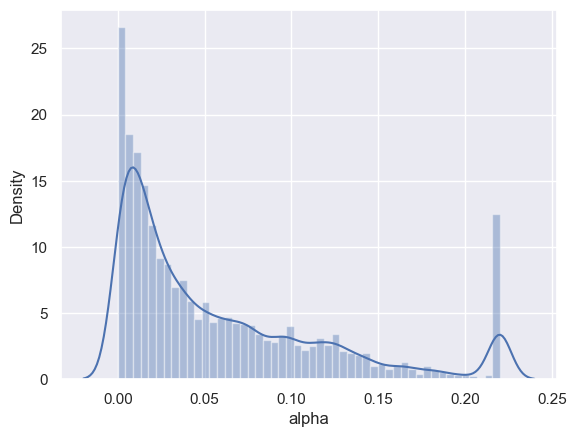

In [44]:
sns.distplot(output["alpha"])

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_74037/2265527681.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output["beta"])


<Axes: xlabel='beta', ylabel='Density'>

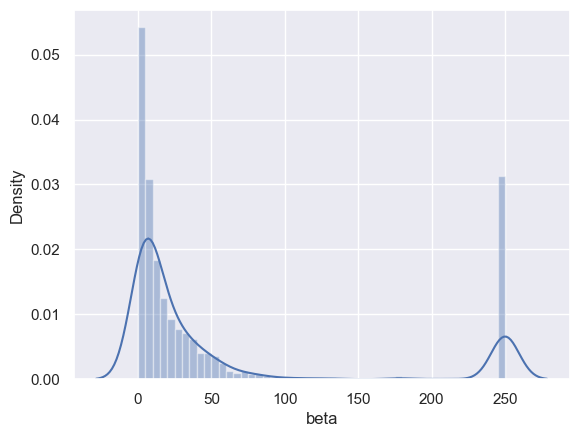

In [45]:
sns.distplot(output["beta"])

In [46]:
rb = output[["TER", "Ta", "E0"]].apply(lambda x: lloyd_taylor_rb(x[0], x[1], x[2]), axis=1)
output["rb"] = rb

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_74037/1812048962.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rb = output[["TER", "Ta", "E0"]].apply(lambda x: lloyd_taylor_rb(x[0], x[1], x[2]), axis=1)


In [47]:
output["rb"]

0        3.870102
1        3.835987
2        3.931900
3        3.851381
4        3.771106
           ...   
64480    0.808899
64481    0.828685
64482    0.830424
64483    0.821418
64484    0.817406
Name: rb, Length: 64485, dtype: float64

In [48]:
output[["Ta", "rb",  "E0"]].apply(lambda x: lloyd_taylor(x[0], x[1], x[2]), axis=1)

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_74037/2087103400.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  output[["Ta", "rb",  "E0"]].apply(lambda x: lloyd_taylor(x[0], x[1], x[2]), axis=1)


0        4.58748
1        4.57013
2        4.78750
3        4.82282
4        4.61976
          ...   
64480    0.75247
64481    0.74814
64482    0.73307
64483    0.71973
64484    0.70704
Length: 64485, dtype: float64

In [49]:
output["TER"]

0        4.58748
1        4.57013
2        4.78750
3        4.82282
4        4.61976
          ...   
64480    0.75247
64481    0.74814
64482    0.73307
64483    0.71973
64484    0.70704
Name: TER, Length: 64485, dtype: float64

In [31]:
output

,DateTime,NEE,NEE_unc,LE,LE_unc,H,H_unc,Tau,Tau_unc,CO2_strg,...,Sunset Time (LST),dNEE,dTa,dRg,NEE_next,E0,window_id,alpha,beta,rb
0,2012-06-22 06:00:00,6.4539,1.63140,87.030,9.32060,19.8800,2.42790,0.21715,0.013563,-0.290640,...,18:05:40.216000,-0.029530,0.003000,-2.885333,5.5680,195.469618,0,3.665269e-13,1.330226e-09,5.437834
1,2012-06-22 06:30:00,5.5680,0.18280,97.393,3.81670,13.8530,1.16120,0.23361,0.012930,-0.083710,...,18:05:40.486000,-0.022553,0.013000,5.368000,4.8914,195.469618,0,3.665269e-13,1.330226e-09,5.444776
2,2012-06-22 07:00:00,4.8914,0.35831,135.540,6.00190,28.2090,4.08820,0.22873,0.013813,-0.043682,...,18:05:40.756000,0.007123,0.017000,-3.310667,5.1051,195.469618,0,3.665269e-13,1.330226e-09,5.829283
3,2012-06-22 07:30:00,5.1051,0.24332,166.290,8.95920,22.3040,2.31180,0.26517,0.016773,-0.044093,...,18:05:41.026000,-0.050813,-0.013333,-3.988000,3.5807,195.469618,0,3.665269e-13,1.330226e-09,6.039286
4,2012-06-22 08:00:00,3.5807,1.33500,129.660,16.24900,-4.5913,1.89220,0.25665,0.015298,0.289860,...,18:05:41.296000,0.212320,-0.000667,0.468000,9.9503,195.469618,0,3.665269e-13,1.330226e-09,5.659396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64480,2019-12-31 16:00:00,NaN,0.10695,NaN,1.22710,NaN,1.24720,0.01470,0.001200,0.083800,...,18:06:33.026000,NaN,-0.038333,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14,0.699978
64481,2019-12-31 16:30:00,NaN,0.06780,NaN,0.57368,NaN,0.77800,0.00688,0.000429,0.097900,...,18:06:33.618000,NaN,-0.027667,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14,0.675423
64482,2019-12-31 17:00:00,NaN,0.19298,NaN,0.34905,NaN,0.76512,0.00200,0.000273,0.180620,...,18:06:34.211000,NaN,-0.009000,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14,0.647129
64483,2019-12-31 17:30:00,NaN,0.35412,NaN,0.50104,NaN,1.63450,0.01180,0.001090,-0.093600,...,18:06:34.803000,NaN,-0.015333,0.000000,NaN,71.593923,2766,8.030925e-18,2.215540e-14,0.630631


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_74037/1551583255.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_night_data["NEE_filled"])
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_74037/1551583255.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output["

<Axes: xlabel='NEE_filled', ylabel='Density'>

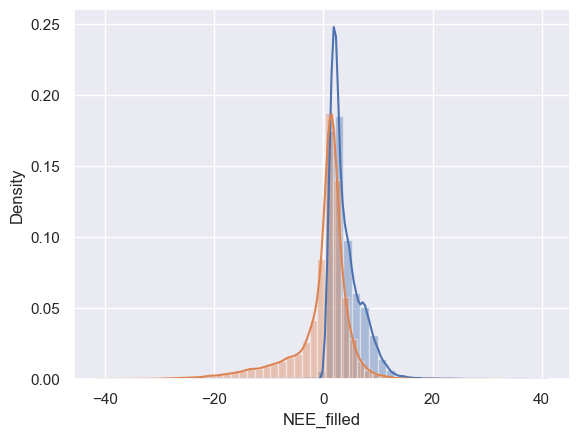

In [50]:
sns.distplot(final_night_data["NEE_filled"])
sns.distplot(output["NEE_filled"])

In [51]:
normaltest(final_night_data["NEE_filled"])

NormaltestResult(statistic=26339.131196708797, pvalue=0.0)

In [52]:
normaltest(output["NEE_filled"])

NormaltestResult(statistic=25401.81570351349, pvalue=0.0)

In [53]:
output.to_parquet("final_day_data.parquet")